#### 該文件包含1,338個案例，即目前已經登記過的保險計劃受益者、病人特點和計劃計入的總醫療費用特徵:

* age:表示主要受益者年齡
* sex:性別
* bmi:身體質量指數,理想BMI在18.5~24.9之間
* children:表示保險計劃中所包括的孩子/受撫養者的數量
* smoker:表示被保險人是否經常吸煙
* region:受益者在美國的居住地-東北(northeast), 東南(sotheast), 西南(southwest)和東北(northwest)
* charges:醫療費用

#### 目的:檢測與醫療費用相關之變量，找出在醫療費用上具高風險的人

# Answer
先定義醫療費用高風險是指會花費較多的醫療費用。 將數值型數據標準化、類別型數據做label encoding，BMI雖然本來是數值型數據，但因為理想的BMI值在18.5~24.9之間，故新增一個欄位IsIdealBMI分出BMI在理想範圍內和不在理想範圍內的人，從corrmat看出，吸菸者、年紀大、BMI指數不在理想值內者與醫療費用較相關，可以推測同時具備這三個條件的人，醫療費用具高風險。

但放進下面使用的模型跑RMSE值都高達四位數，測試樣本跟訓練樣本的R square值差異頗大，可能這幾種模型都不太適合這個案例？
### 下方是code

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [2]:
df = pd.read_csv('insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
df.describe()
#四個欄位為數值

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
#三個欄位為類別做LabelEncoding
labelencoder = LabelEncoder()
df['sex'] = labelencoder.fit_transform(df['sex'])
df['smoker'] = labelencoder.fit_transform(df['smoker'])
df['region'] = labelencoder.fit_transform(df['region'])

In [6]:
#bmi:身體質量指數,理想BMI在18.5~24.9之間，新增一欄將理想Bmi分類別
df_bmi= pd.DataFrame(df['bmi'])
df_bmi.loc[(df['bmi'] >= 18.5) & (df['bmi'] <= 24.9), 'IsIdealBMI'] = 1
df_bmi.loc[(df['bmi'] < 18.5) | (df['bmi'] > 24.9), 'IsIdealBMI'] = 0
df.insert(loc=3, column='IsIdealBMI', value=df_bmi['IsIdealBMI'])
df['IsIdealBMI'] = labelencoder.fit_transform(df['IsIdealBMI'])
df

,age,sex,bmi,IsIdealBMI,children,smoker,region,charges
0,19,0,27.900,0,0,1,3,16884.92400
1,18,1,33.770,0,1,0,2,1725.55230
2,28,1,33.000,0,3,0,2,4449.46200
3,33,1,22.705,1,0,0,1,21984.47061
4,32,1,28.880,0,0,0,1,3866.85520
...,...,...,...,...,...,...,...,...
1333,50,1,30.970,0,3,0,1,10600.54830
1334,18,0,31.920,0,0,0,0,2205.98080
1335,18,0,36.850,0,0,0,2,1629.83350
1336,21,0,25.800,0,0,0,3,2007.94500


In [7]:
df.head()

,age,sex,bmi,IsIdealBMI,children,smoker,region,charges
0,19,0,27.900,0,0,1,3,16884.92400
1,18,1,33.770,0,1,0,2,1725.55230
2,28,1,33.000,0,3,0,2,4449.46200
3,33,1,22.705,1,0,0,1,21984.47061
4,32,1,28.880,0,0,0,1,3866.85520


In [8]:
#正規化數值型欄位
minmax = preprocessing.MinMaxScaler()
x_minmax = minmax.fit_transform(df[['age', 'children','bmi']])
x_minmax

array([[0.02173913, 0.        , 0.3212268 ],
       [0.        , 0.2       , 0.47914985],
       [0.2173913 , 0.6       , 0.45843422],
       ...,
       [0.        , 0.        , 0.56201238],
       [0.06521739, 0.        , 0.26472962],
       [0.93478261, 0.        , 0.35270379]])

In [9]:
x_minmax= pd.DataFrame(x_minmax, columns=['age', 'children','bmi'])
x_minmax

,age,children,bmi
0,0.021739,0.0,0.321227
1,0.000000,0.2,0.479150
2,0.217391,0.6,0.458434
3,0.326087,0.0,0.181464
4,0.304348,0.0,0.347592
...,...,...,...
1333,0.695652,0.6,0.403820
1334,0.000000,0.0,0.429379
1335,0.000000,0.0,0.562012
1336,0.065217,0.0,0.264730


In [10]:
new_df= pd.concat([x_minmax.reset_index(drop=True),df[['sex','IsIdealBMI','smoker','region','charges']]],axis=1)
new_df= new_df.drop(columns = ['bmi'])
new_df

,age,children,sex,IsIdealBMI,smoker,region,charges
0,0.021739,0.0,0,0,1,3,16884.92400
1,0.000000,0.2,1,0,0,2,1725.55230
2,0.217391,0.6,1,0,0,2,4449.46200
3,0.326087,0.0,1,1,0,1,21984.47061
4,0.304348,0.0,1,0,0,1,3866.85520
...,...,...,...,...,...,...,...
1333,0.695652,0.6,1,0,0,1,10600.54830
1334,0.000000,0.0,0,0,0,0,2205.98080
1335,0.000000,0.0,0,0,0,2,1629.83350
1336,0.065217,0.0,0,0,0,3,2007.94500


In [11]:
new_df.columns

Index(['age', 'children', 'sex', 'IsIdealBMI', 'smoker', 'region', 'charges'], dtype='object')

In [12]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         1338 non-null   float64
 1   children    1338 non-null   float64
 2   sex         1338 non-null   int64  
 3   IsIdealBMI  1338 non-null   int64  
 4   smoker      1338 non-null   int64  
 5   region      1338 non-null   int64  
 6   charges     1338 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 73.3 KB


In [13]:
new_df.sort_values(by=['charges'], ascending=False)

,age,children,sex,IsIdealBMI,smoker,region,charges
543,0.782609,0.0,0,0,1,2,63770.42801
1300,0.586957,0.0,1,0,1,2,62592.87309
1230,0.739130,0.6,1,0,1,1,60021.39897
577,0.282609,0.2,0,0,1,0,58571.07448
819,0.326087,0.0,0,0,1,1,55135.40209
...,...,...,...,...,...,...,...
22,0.000000,0.0,1,0,0,2,1137.01100
663,0.000000,0.0,1,0,0,2,1136.39940
1244,0.000000,0.0,1,0,0,2,1135.94070
808,0.000000,0.0,1,0,0,2,1131.50660


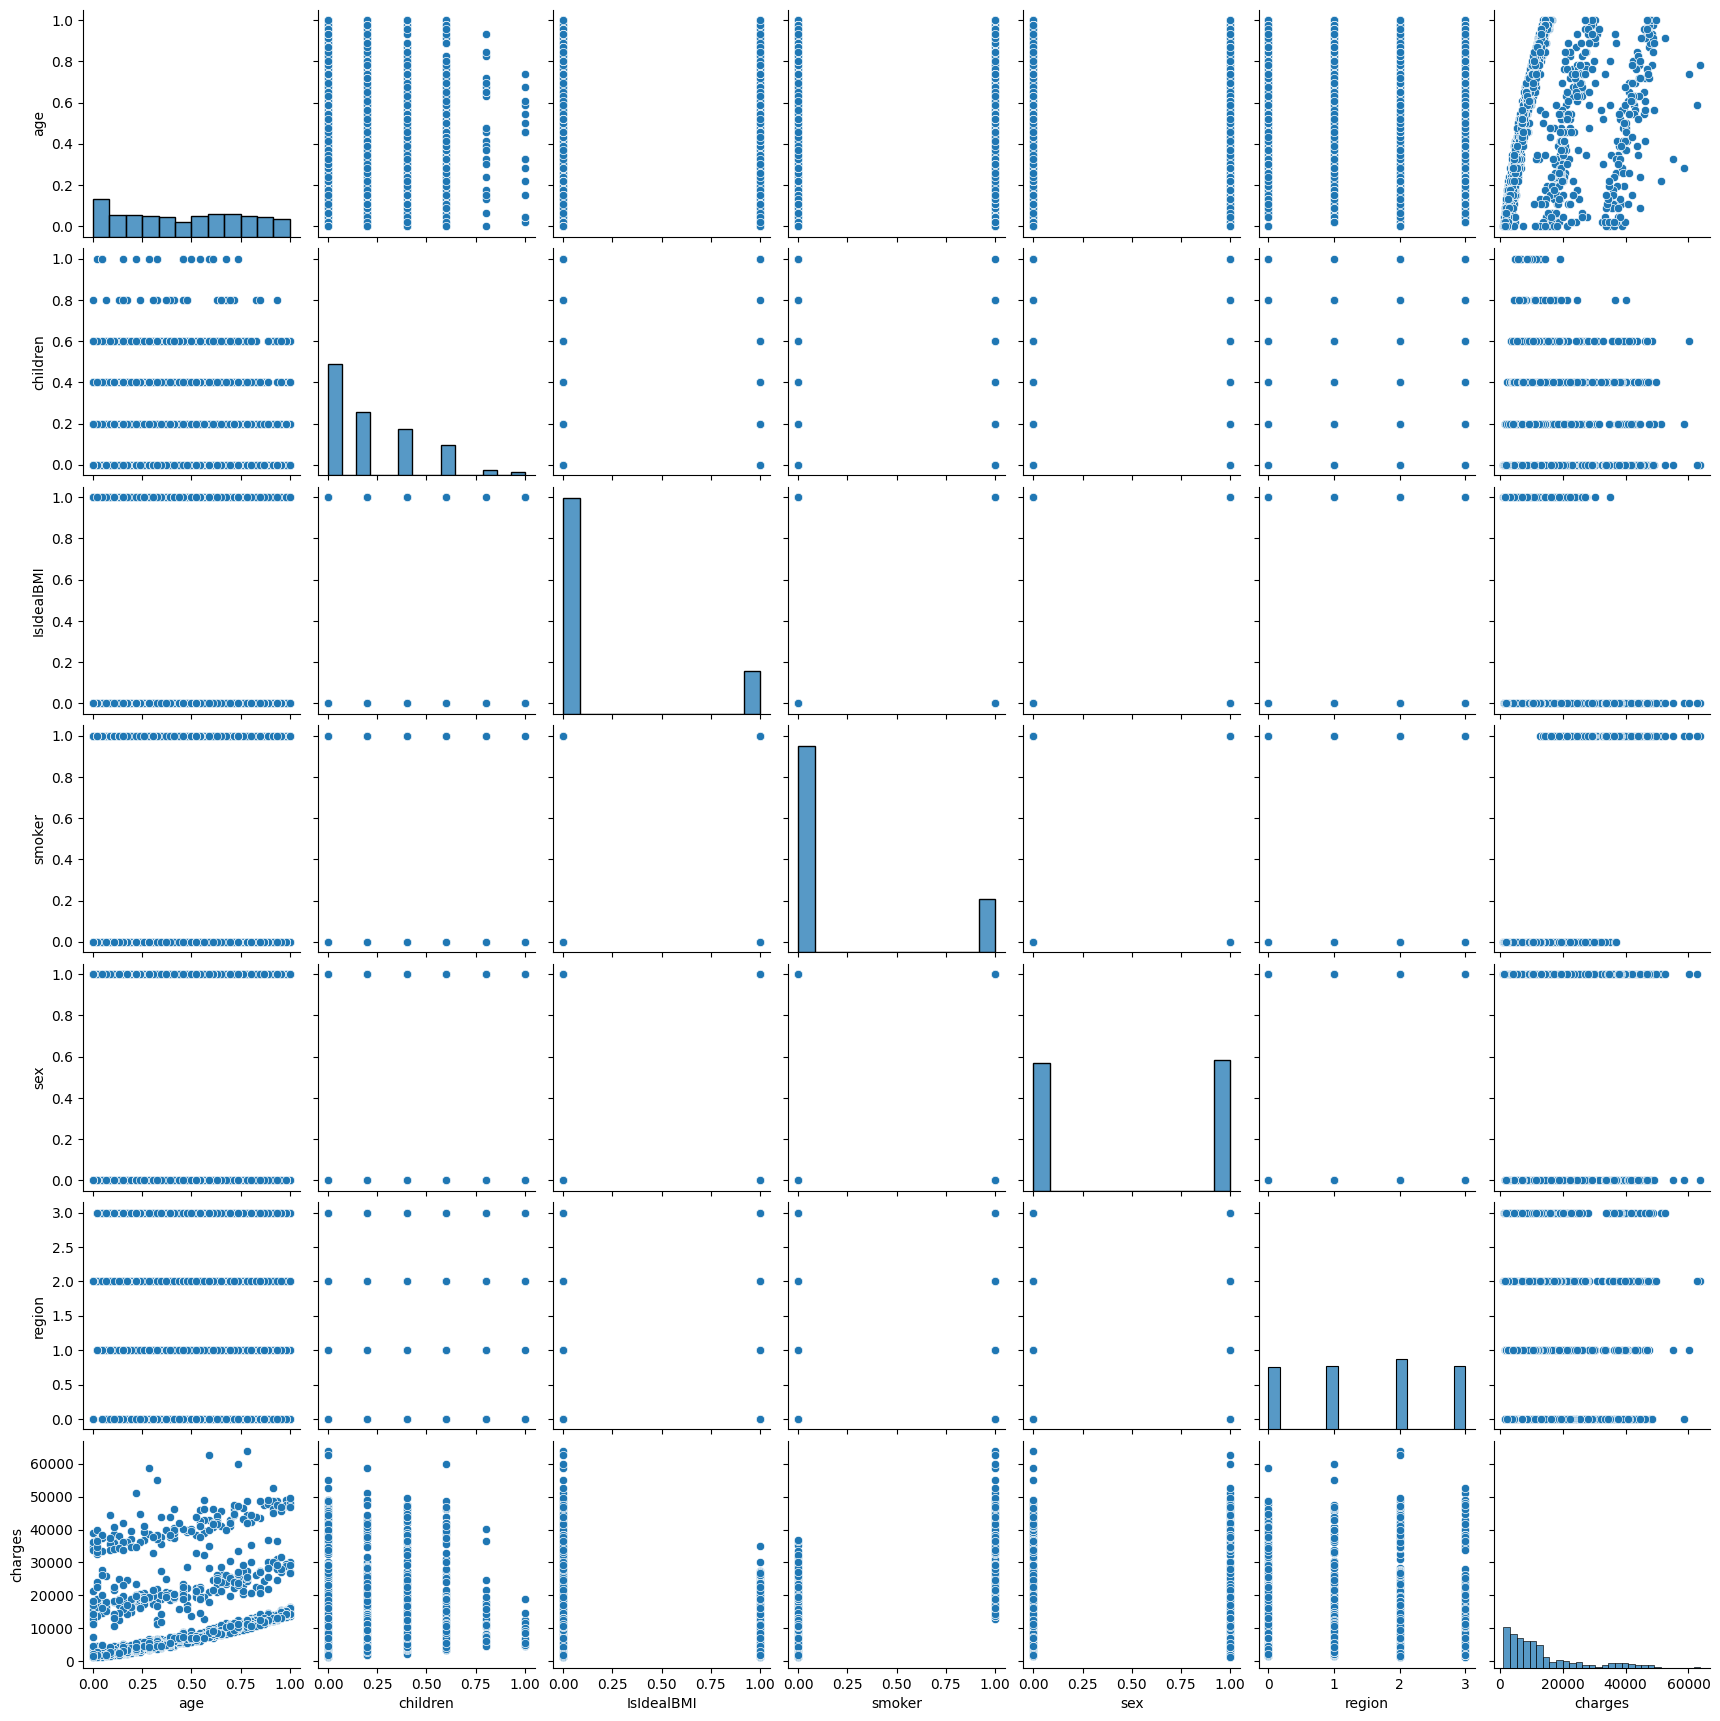

In [14]:
sns.pairplot(new_df[['age', 'children','IsIdealBMI', 'smoker','sex','region','charges']])

<Axes: >

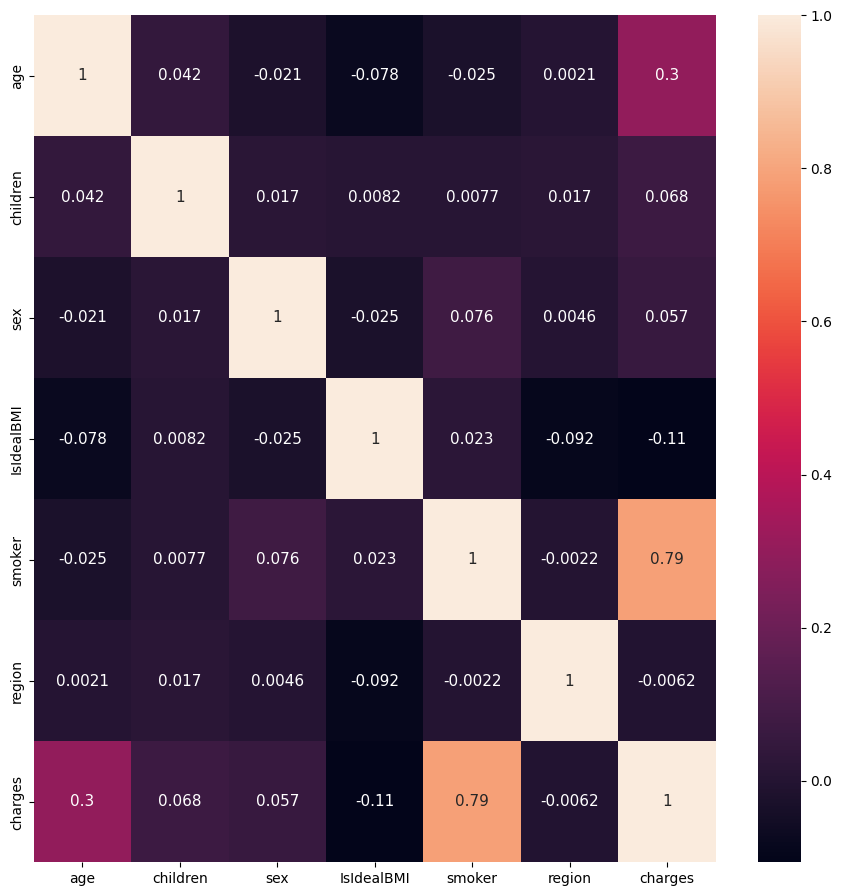

In [15]:
corrmat = new_df.corr()
fig, ax = plt.subplots(figsize = (11, 11))
sns.heatmap(corrmat, annot = True, annot_kws={'size': 11})

In [16]:
new_df.iloc[:,6]

0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
1337    29141.36030
Name: charges, Length: 1338, dtype: float64

In [18]:
X = new_df.iloc[:, 0:6].values
y= new_df.iloc[:,6].values.reshape(-1,1)

# 切分訓練資料和測試資料


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 888)

In [20]:
print(f"Shape of X_train:{X_train.shape}")
print(f"Shape of X_test:{X_test.shape}")
print(f"Shape of y_train:{y_train.shape}")
print(f"Shape of y_test{y_test.shape}")

Shape of X_train:(1070, 6)
Shape of X_test:(268, 6)
Shape of y_train:(1070, 1)
Shape of y_test(268, 1)


In [21]:
new_df.isnull().sum()

age           0
children      0
sex           0
IsIdealBMI    0
smoker        0
region        0
charges       0
dtype: int64

In [22]:
new_df.describe()

,age,children,sex,IsIdealBMI,smoker,region,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,0.461022,0.218984,0.505232,0.165919,0.204783,1.515695,13270.422265
std,0.305434,0.241099,0.500160,0.372147,0.403694,1.104885,12110.011237
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1121.873900
25%,0.195652,0.000000,0.000000,0.000000,0.000000,1.000000,4740.287150
50%,0.456522,0.200000,1.000000,0.000000,0.000000,2.000000,9382.033000
75%,0.717391,0.400000,1.000000,0.000000,0.000000,2.000000,16639.912515
max,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,63770.428010


In [23]:
# 1:age:表示主要受益者年齡
# 2:children:表示保險計劃中所包括的孩子/受撫養者的數量
# 3:sex:性別
# 4:IsIdealBMI:表示是否在理想BMI範圍
# 5:smoker:表示被保險人是否經常吸煙
# 6:region:受益者在美國的居住地-東北(northeast), 東南(sotheast), 西南(southwest)和東北(northwest)
# 7:charges:醫療費用

# Linear

In [24]:
from sklearn.linear_model import LinearRegression
regressor_linear = LinearRegression()
regressor_linear.fit(X_train, y_train)

LinearRegression()

In [26]:
from sklearn.metrics import r2_score

# R2 score，即決定係數，反映Y的全部變異能通過迴歸關係被所有X解釋的比例。
y_pred_linear_train = regressor_linear.predict(X_train)
r2_score_linear_train = r2_score(y_train, y_pred_linear_train)

y_pred_linear_test = regressor_linear.predict(X_test)
r2_score_linear_test = r2_score(y_test, y_pred_linear_test)

# RMSE一般指均方根誤差(標準誤差)，可衡量預測值和實際值之間的平均差異，藉此估計預測模型預測目標值的準確度
#RMSE越低越好
rmse_linear_train = (np.sqrt(mean_squared_error(y_train, y_pred_linear_train)))
rmse_linear_test = (np.sqrt(mean_squared_error(y_test, y_pred_linear_test)))

print('R2_score (train): ', r2_score_linear_train)
print('R2_score (test): ', r2_score_linear_test)
print("RMSE (train): ", rmse_linear_train)
print("RMSE (test): ", rmse_linear_test)

R2_score (train):  0.7529782419966949
R2_score (test):  0.610771527127168
RMSE (train):  6213.560434890851
RMSE (test):  6411.595889090246


In [27]:
import statsmodels.api as sm
from scipy import stats

In [28]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2).fit()
print(est.summary())
# P  < .05, P  < .01,P  < .001

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     612.3
Date:                Mon, 26 Jun 2023   Prob (F-statistic):               0.00
Time:                        18:47:19   Log-Likelihood:                -13592.
No. Observations:                1338   AIC:                         2.720e+04
Df Residuals:                    1331   BIC:                         2.723e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2991.0613    471.155      6.348      0.0

In [29]:
# 1:age:表示主要受益者年齡
# 2:children:表示保險計劃中所包括的孩子/受撫養者的數量
# 3:sex:性別
# 4:IsIdealBMI:表示是否在理想BMI範圍
# 5:smoker:表示被保險人是否經常吸煙
# 6:region:受益者在美國的居住地-東北(northeast), 東南(sotheast), 西南(southwest)和東北(northwest)
# 7:charges:醫療費用

In [30]:
new_df

,age,children,sex,IsIdealBMI,smoker,region,charges
0,0.021739,0.0,0,0,1,3,16884.92400
1,0.000000,0.2,1,0,0,2,1725.55230
2,0.217391,0.6,1,0,0,2,4449.46200
3,0.326087,0.0,1,1,0,1,21984.47061
4,0.304348,0.0,1,0,0,1,3866.85520
...,...,...,...,...,...,...,...
1333,0.695652,0.6,1,0,0,1,10600.54830
1334,0.000000,0.0,0,0,0,0,2205.98080
1335,0.000000,0.0,0,0,0,2,1629.83350
1336,0.065217,0.0,0,0,0,3,2007.94500


In [31]:
#移除 x3變數 sex 後重跑 

X = new_df.iloc[:, [0,1,3,4,5]].values
y= new_df.iloc[:,6].values.reshape(-1,1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 888)
print(f"Shape of X_train:{X_train.shape}")
print(f"Shape of X_test:{X_test.shape}")
print(f"Shape of y_train:{y_train.shape}")
print(f"Shape of y_test{y_test.shape}")


Shape of X_train:(1070, 5)
Shape of X_test:(268, 5)
Shape of y_train:(1070, 1)
Shape of y_test(268, 1)


In [33]:
from sklearn.linear_model import LinearRegression
regressor_linear2 = LinearRegression()
regressor_linear2.fit(X_train, y_train)

from sklearn.metrics import r2_score
y_pred_linear2_train = regressor_linear2.predict(X_train)
r2_score_linear2_train = r2_score(y_train, y_pred_linear2_train)

y_pred_linear2_test = regressor_linear2.predict(X_test)
r2_score_linear2_test = r2_score(y_test, y_pred_linear2_test)

rmse_linear2_train = (np.sqrt(mean_squared_error(y_train, y_pred_linear2_train)))
rmse_linear2_test = (np.sqrt(mean_squared_error(y_test, y_pred_linear2_test)))

print('R2_score (train): ', r2_score_linear2_train)
print('R2_score (test): ', r2_score_linear2_test)
print("RMSE (train): ", rmse_linear2_train)
print("RMSE (test): ", rmse_linear2_test)

R2_score (train):  0.7529599093697175
R2_score (test):  0.6110224302645342
RMSE (train):  6213.790999139908
RMSE (test):  6409.529045363723


In [35]:
import statsmodels.api as sm
from scipy import stats
X2 = sm.add_constant(X)
est = sm.OLS(y, X2).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     735.4
Date:                Mon, 26 Jun 2023   Prob (F-statistic):               0.00
Time:                        18:50:08   Log-Likelihood:                -13592.
No. Observations:                1338   AIC:                         2.720e+04
Df Residuals:                    1332   BIC:                         2.723e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2987.5099    438.657      6.811      0.0

# Polynomial

In [36]:
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree = 2)
X_poly = poly_reg.fit_transform(X_train)

regressor_poly2 = LinearRegression()
regressor_poly2.fit(X_poly, y_train)

LinearRegression()

In [46]:
y_pred_poly2_train = regressor_poly2.predict(poly_reg.fit_transform(X_train))
r2_score_poly2_train = r2_score(y_train, y_pred_poly2_train)

y_pred_poly2_test = regressor_poly2.predict(poly_reg.fit_transform(X_test))
r2_score_poly2_test = r2_score(y_test, y_pred_poly2_test)

rmse_poly2_train = (np.sqrt(mean_squared_error(y_train, y_pred_poly2_train)))
rmse_poly2_test = (np.sqrt(mean_squared_error(y_test, y_pred_poly2_test)))

print('R2_score (train): ', r2_score_poly2_train)
print('R2_score (test): ', r2_score_poly2_test)
print("RMSE (train): ", rmse_poly2_train)
print("RMSE (test): ", rmse_poly2_test)

R2_score (train):  0.7921801015870517
R2_score (test):  0.6677959868992407
RMSE (train):  5699.233975162724
RMSE (test):  5923.334762692605


# Lasso

In [39]:
lasso = Lasso(alpha = 0.5) # , positive=True
lasso.fit(X_train,y_train)

y_pred_lasso_train = lasso.predict(X_train)
r2_score_lasso_train = lasso.score(X_train, y_train)

y_pred_lasso_test = lasso.predict(X_test)
r2_score_lasso_test = lasso.score(X_test, y_test)

rmse_lasso_train = (np.sqrt(mean_squared_error(y_train, y_pred_lasso_train)))
rmse_lasso_test = (np.sqrt(mean_squared_error(y_test, y_pred_lasso_test)))

print("coef：")
for i, j in zip(new_df.columns, lasso.coef_):
    print(i, j)

coef：
age 12366.188933876378
children 1860.1771539972633
sex -3365.596326985161
IsIdealBMI 24629.96765822443
smoker -23.571948125053066


In [40]:
print("R2_score (train): ",r2_score_lasso_train)
print("R2_score (test):", r2_score_lasso_test)
print("train_RMSE (train): ", rmse_lasso_train)
print("test_RMSE: (test) ", rmse_lasso_test)

R2_score (train):  0.7529598449769181
R2_score (test): 0.6110266394177843
train_RMSE (train):  6213.791808974802
test_RMSE: (test)  6409.494366290817


# Ridge

In [42]:
ridgeReg = Ridge(alpha=0.5)
ridgeReg.fit(X_train, y_train)

y_pred_ridge_train = ridgeReg.predict(X_train)
r2_score_ridge_train = ridgeReg.score(X_train, y_train)

y_pred_ridge_test = ridgeReg.predict(X_test)
r2_score_ridge_test = ridgeReg.score(X_test, y_test)

rmse_ridge_train = (np.sqrt(mean_squared_error(y_train, y_pred_ridge_train)))
rmse_ridge_test = (np.sqrt(mean_squared_error(y_test, y_pred_ridge_test)))

print("coef：")
for i, j in zip(new_df.columns, ridgeReg.coef_[0]):
    print(i, j)

coef：
age 12308.517285044572
children 1857.5480984353385
sex -3361.687881151019
IsIdealBMI 24564.018135794915
smoker -24.121030306501435


In [43]:
print("R2_score (train): ",r2_score_ridge_train)
print("R2_score (test):", r2_score_ridge_test)
print("train_RMSE: ", rmse_ridge_train)
print("test_RMSE: ", rmse_ridge_test)

R2_score (train):  0.7529524121152527
R2_score (test): 0.6117942169079553
train_RMSE:  6213.885287517846
test_RMSE:  6403.167180936461


In [60]:
data = {
    'model': ['LR', 'LR2', 'Polynomial', 'Lasso', 'Ridge'],
    'R2_score (train)': [r2_score_linear_train, r2_score_linear2_train, r2_score_poly2_train, r2_score_lasso_train, r2_score_ridge_train],
    'R2_score (test)': [r2_score_linear_test, r2_score_linear2_test, r2_score_poly2_test, r2_score_lasso_test, r2_score_ridge_test],
    'RMSE (train)': [rmse_linear_train, rmse_linear2_train, rmse_poly2_train, rmse_lasso_train, rmse_ridge_train],
    'RMSE (test)': [rmse_linear_test, rmse_linear2_test, rmse_poly2_test, rmse_lasso_test, rmse_ridge_test]
}
df = pd.DataFrame(data)
print(df)

        model  R2_score (train)  R2_score (test)  RMSE (train)  RMSE (test)
0          LR          0.752978         0.610772   6213.560435  6411.595889
1         LR2          0.752960         0.611022   6213.790999  6409.529045
2  Polynomial          0.792180         0.667796   5699.233975  5923.334763
3       Lasso          0.752960         0.611027   6213.791809  6409.494366
4       Ridge          0.752952         0.611794   6213.885288  6403.167181


In [ ]:
#勉強要選一個模型的話應該是選Polynomial